<a href="https://colab.research.google.com/github/AKIYAMA-Keito/Colab-repo/blob/main/AWP_nondef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np

Step1 Tensorflowチュートリアル4から引用

version2


データセットを読み込んで正規化する．

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
random_index_train = np.array(range(len(x_train)))
np.random.shuffle(random_index_train)
x_train = x_train[random_index_train][:1000]
y_train = y_train[random_index_train][:1000]
x_train = x_train / 255.0
x_test = x_test/255.0
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

11490434/11490434 [==============================] - 0s 0us/step


データセットをシャッフルしてバッチ化する．

In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
).batch(1000)
test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
).batch(1)

CNNモデルを定義しインスタンスを取り出す．

In [4]:
class CNNModel(Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation = "relu")
        self.flatten = Flatten()
        self.d1 = Dense(128, activation = "relu")
        self.d2 = Dense(10)
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

model = CNNModel()

損失関数とoptmizerを選択する．

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()

損失関数とoptimizerの尺度評価のための関数を導入する．

In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

モデルを訓練するための関数train_stepを定義する．
予測値と正解ラベルの間の損失関数の勾配を最適化する．

In [7]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training = True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

モデルをテストするための関数test_stepを定義する．

In [8]:
@tf.function
def test_step(images, labels):
    predictions = model(images, training = False)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

学習を実行してテストし，結果を出力する．

In [9]:
EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    for train_images, train_labels in train_ds:
        train_step(train_images, train_labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )

Epoch 1, Loss: 2.296882152557373, Accuracy: 12.199999809265137, Test Loss: 1.9357314109802246, Test Accuracy: 46.650001525878906
Epoch 2, Loss: 1.9050135612487793, Accuracy: 51.099998474121094, Test Loss: 1.5488656759262085, Test Accuracy: 69.44000244140625
Epoch 3, Loss: 1.4882415533065796, Accuracy: 75.70000457763672, Test Loss: 1.2314039468765259, Test Accuracy: 75.97000122070312


AWPのアルゴリズムを記述する．
まず，学習済みのmodelから重みを取り出してvを加えて再設定する．

In [10]:
# weights = model.get_weights()
# ordinary_weights = weights
# new_weights = []
# v_array = []
# for w in weights:
#   v = 0.02 * np.random.rand() - 0.01
#   new_weights.append(w + v)
#   v_array.append(tf.fill(w.shape, v))
# model.set_weights(new_weights)

In [11]:
weights = model.get_weights()
ordinary_weights = weights
v_array = []
for w in weights:
  v = 0.02 * np.random.rand() - 0.01
  v_array.append(tf.fill(w.shape, v))

Step2

In [12]:
# @tf.function
def adversary(dataset, additive_weights, eps1 = 1, eta1 = 0.1):
    weights = model.get_weights()
    new_weights = []
    for w, v in zip(weights, additive_weights):
      new_weights.append(w + v)
    model.set_weights(new_weights)

    adversarial_image_list = []
    # eps1 = 1
    # eta1 = 0.1
    for (images, labels) in dataset:
      for (image, label) in zip(images, labels):
        image = tf.Variable([image])

        initial_noise = 2 * eps1 * np.random.rand() - eps1
        image_dashed = tf.add(image, initial_noise)

        # この書き方でも，initial_noiseが一様に入ってしまっている．
        # tf.Variableで1次元追加しているから，より内側のループを作らないといけないよ
        # image_dashed_list = []
        # for image_0 in image:
        #   for image_h in image_0:
        #     for image_v in image_h:
        #       for image_pixel in image_v:
        #         initial_noise = 2 * eps1 * np.random.rand() - eps1
        #         image_pixel_dashed = tf.add(image_pixel, initial_noise)
        # image_dashed_list.append(image_pixel_dashed)
        # # image_dashed = np.array(image_dashed_list)
        # image_dashed = tf.convert_to_tensor(image_dashed_list)
        # print(image_dashed.numpy())

        for j in range(5):
          with tf.GradientTape() as tape:
            tape.watch(image_dashed)
            prediction = model(image_dashed, training = True)
            loss = loss_object(label, prediction)
          gradients = tape.gradient(loss, image_dashed)
          image_med = tf.add(image_dashed, tf.multiply(eta1, gradients))
          difference = tf.subtract(image_med, image)
          if tf.norm(difference) <= eps1:
            image_dashed = image_med 
          else:
            image_dashed = difference
            image_dashed = tf.multiply(image_dashed, eps1)
            image_dashed = tf.divide(image_dashed, tf.norm(difference))
            image_dashed = tf.add(image_dashed, image)
        adversarial_image_list.append(image_dashed[0])
        adversarial_image = np.array(adversarial_image_list)

    return adversarial_image

    # def calculate_loss(adversarial_dataset, batch_size = 100):
    #   # batch_size = 100
    #   loss_sum = 0.0
    #   for (images, labels) in adversarial_ds:
    #     predictions = model(images, training = True)
    #     loss = loss_object(labels, predictions)
    #     loss_sum_batch = loss * batch_size
    #     loss_sum = tf.add(loss_sum_batch, loss_sum)
    #   average_loss = tf.divide(loss_sum, 1000)
    # return average_loss

In [13]:
# # def adversary(dataset, additive_weights, eps1 = 1, eta1 = 0.1):
# weights = model.get_weights()
# new_weights = []
# for w, v in zip(weights, v_array):
#   new_weights.append(w + v)
# model.set_weights(new_weights)

# adversarial_image_list = []
# eps1 = 1
# eta1 = 0.1
# for (images, labels) in train_ds:
#   for (image, label) in zip(images, labels):
#     image = tf.Variable([image])

#     initial_noise = 2 * eps1 * np.random.rand() - eps1
#     image_dashed = tf.add(image, initial_noise)
#     # print(image)
#     # print(image_dashed)

#     # この書き方でも，initial_noiseが一様に入ってしまっている．
#     # tf.Variableで1次元追加しているから，より内側のループを作らないといけないよ
#     # image_dashed_list = []
#     # for image_0 in image:
#     #   for image_h in image_0:
#     #     for image_v in image_h:
#     #       for image_pixel in image_v:
#     #         initial_noise = 2 * eps1 * np.random.rand() - eps1
#     #         image_pixel_dashed = tf.add(image_pixel, initial_noise)
#     # image_dashed_list.append(image_pixel_dashed)
#     # # image_dashed = np.array(image_dashed_list)
#     # image_dashed = tf.convert_to_tensor(image_dashed_list)
#     # print(image_dashed.numpy())

#     for j in range(1):
#       with tf.GradientTape() as tape:
#         tape.watch(image_dashed)
#         prediction = model(image_dashed, training = False)
#         # print(prediction)
#         loss = loss_object(label, prediction)
#       gradients = tape.gradient(loss, image_dashed)
#       image_med = tf.add(image_dashed, tf.multiply(eta1, gradients))
#       difference = tf.subtract(image_med, image)
#       if tf.norm(difference) <= eps1:
#         image_dashed = image_med 
#       else:
#         image_dashed = difference
#         image_dashed = tf.multiply(image_dashed, eps1)
#         image_dashed = tf.divide(image_dashed, tf.norm(difference))
#         image_dashed = tf.add(image_dashed, image)
#     adversarial_image_list.append(image_dashed[0])
#     adversarial_image = np.array(adversarial_image_list)

# print(adversarial_image[0] - x_train[0])

# # print(adversarial_image)

In [14]:
x_adversarial = adversary(train_ds, v_array)

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

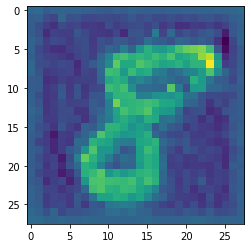

8


In [16]:
# for i in range(10):
plt.imshow(np.squeeze(x_adversarial[0] - x_train[0]))
plt.show()
print(y_train[0])

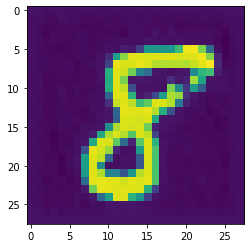

8


In [17]:
plt.imshow(np.squeeze(x_adversarial[0]))
plt.show()
print(y_train[0])

In [18]:
# %matplotlib inline
# for i in range(10):
#   plt.imshow(np.squeeze(x_adversarial[i]))
#   plt.show()
#   print(y_train[i])

In [19]:
adversarial_ds = tf.data.Dataset.from_tensor_slices(
    (x_adversarial, y_train)
).batch(100)

In [20]:
def calculate_loss(dataset, batch_size = 100):
  batch_size = 100
  loss_sum = 0.0
  for (images, labels) in adversarial_ds:
    predictions = model(images, training = True)
    loss = loss_object(labels, predictions)
    loss_sum_batch = loss * batch_size
    loss_sum = tf.add(loss_sum_batch, loss_sum)
  average_loss = tf.divide(loss_sum, 1000)
  return average_loss

In [21]:
# x_adversarial_list = []
# eps1 = 1
# eta1 = 0.1
# for i, (images, labels) in enumerate(train_ds):
#   for (image, label) in zip(images, labels):
#     image = tf.Variable([image])

#     initial_noise = 2 * eps1 * np.random.rand() - eps1
#     image_dashed = tf.add(image, initial_noise)

#     # この書き方でも，initial_noiseが一様に入ってしまっている．
#     # tf.Variableで1次元追加しているから，より内側のループを作らないといけないよ
#     # image_dashed_list = []
#     # for image_0 in image:
#     #   for image_h in image_0:
#     #     for image_v in image_h:
#     #       for image_pixel in image_v:
#     #         initial_noise = 2 * eps1 * np.random.rand() - eps1
#     #         image_pixel_dashed = tf.add(image_pixel, initial_noise)
#     # image_dashed_list.append(image_pixel_dashed)
#     # # image_dashed = np.array(image_dashed_list)
#     # image_dashed = tf.convert_to_tensor(image_dashed_list)
#     # print(image_dashed.numpy())

#     for j in range(5):
#       with tf.GradientTape() as tape:
#         tape.watch(image_dashed)
#         prediction = model(image_dashed, training = True)
#         loss = loss_object(label, prediction)
#       gradients = tape.gradient(loss, image_dashed)
#       image_med = tf.add(image_dashed, tf.multiply(eta1, gradients))
#       difference = tf.subtract(image_med, image)
#       if tf.norm(difference) <= eps1:
#         image_dashed = image_med 
#       else:
#         image_dashed = difference
#         image_dashed = tf.multiply(image_dashed, eps1)
#         image_dashed = tf.divide(image_dashed, tf.norm(difference))
#         image_dashed = tf.add(image_dashed, image)
#     x_adversarial_list.append(image_dashed[0])
# x_adversarial = tf.convert_to_tensor(x_adversarial_list)

Step3

In [22]:
# batch_size = 100
# loss_sum = 0.0
# for (images, labels) in adversarial_ds:
#   predictions = model(images, training = True)
#   loss = loss_object(labels, predictions)
#   loss_sum_batch = loss * batch_size
#   loss_sum = tf.add(loss_sum_batch, loss_sum)
# average_loss = tf.divide(loss_sum, 1000)

In [23]:
# def calculate_loss(dataset, batch_size = 100, additive_noise = v_array):
#   # batch_size = 100
#   loss_sum = 0.0
#   for (images, labels) in dataset:
#     predictions = model(images, training = True)
#     loss = loss_object(labels, predictions)
#     loss_sum_batch = loss * batch_size
#     loss_sum = tf.add(loss_sum_batch, loss_sum)
#   average_loss = tf.divide(loss_sum, 1000)
#   return average_loss

Step4

In [24]:
# o0 = ordinary_weights[0].flatten()
# o1 = ordinary_weights[1].flatten()
# o2 = ordinary_weights[2].flatten()
# o3 = ordinary_weights[3].flatten()
# o4 = ordinary_weights[4].flatten()
# o5 = ordinary_weights[5].flatten()

# ordinary_flatten_weights = [o0, o1, o2, o3, o4, o5]

# w_med_list = []
# for w_layer in ordinary_flatten_weights:
#   w_med = tf.square(w_layer)
#   w_med = tf.add_n(w_med)
#   w_med_list.append(w_med)
# w_fro = tf.add_n(w_med_list)
# w_fro = tf.sqrt(w_fro)

In [25]:
# w_fro = 0.0
# for w in ordinary_weights:
#   w_reshape = tf.reshape(w, [-1])
#   w_med = tf.square(w_reshape)
#   w_med = tf.add_n(w_med)
#   w_fro = tf.add(w_fro, w_med)
# w_fro = tf.sqrt(w_fro)

In [26]:
# from numpy import linalg as LA

In [27]:
w_flat = np.ndarray([])
for w in ordinary_weights:
  w_reshape = tf.reshape(w, [-1])
  print(w_reshape.shape)
  w_flat = np.hstack([w_flat, w_reshape])
w_fro = np.linalg.norm(w_flat)
print(w_fro)
  # w_fro = tf.add(w_fro, np.linalg.norm(w_reshape, ord=2))
# w_fro = tf.sqrt(w_fro)

(288,)
(32,)
(2768896,)
(128,)
(1280,)
(10,)
16.91876054870113


In [32]:
from matplotlib.rcsetup import validate_axisbelow
eps2 = 1
eta2 = 0.1
batch_size = 100


v_updated = v_array
# vの初期値を，step2で固定したvに設定する．

for i in range(5):

  # 重みをw + (現在の)vに設定する　　ここから
  current_weights = []
  for layer_weights, v in zip(ordinary_weights, v_updated):
    current_layer_weight = tf.add(layer_weights, v)
    current_weights.append(current_layer_weight)
  model.set_weights(current_weights)
  # 重みをw + (現在の)vに設定する　　ここまで

  # gradientの計算　　ここから
  with tf.GradientTape() as tape:
    loss = calculate_loss(adversarial_ds)
  gradients = tape.gradient(loss, model.trainable_variables)
  # gradientの計算　　ここまで

  # gradientのノルムの計算　　ここから
  gradients_flat = np.ndarray([])
  for g in gradients:
    g_reshape = tf.reshape(g, [-1])
    gradients_flat = np.hstack([gradients_flat, g_reshape])
  gradients_norm = np.linalg.norm(gradients_flat)
  # gradientのノルムの計算　　ここまで

  # 勾配降下の実行　　ここから
  v_difference = []
  for g, v, w in zip(gradients, v_updated, ordinary_weights):
    g = tf.divide(g, gradients_norm)
    g = tf.multiply(g, w_fro)
    g = tf.multiply(eta2, g)
    v_med = tf.add(v, g)
  # 勾配降下の実行　　ここまで

  # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここから
    v_difference.append(tf.subtract(v_med, w))
  v_difference_flat = np.ndarray([])
  for v_flat in v_difference:
    v_flat_reshape = tf.reshape(v_flat, [-1])
    # print(g_reshape.shape)
    v_difference_flat = np.hstack([v_difference_flat, v_flat_reshape])
  v_difference_norm = np.linalg.norm(v_difference_flat)
  # (現在の)vと(元の重み)wの差分と，　そのノルムを計算　　ここまで

  # 射影の実行　　ここから
  if v_difference_norm <= eps2:
    v_hat = v_med 
  else:
    v_hat = v_difference
    for v_hat_med, w in zip(v_hat, ordinary_weights):
      v_hat_med = tf.multiply(v_hat_med, eps2)
      v_hat_med = tf.divide(v_hat_med, v_difference_norm)
      v_hat_med = tf.add(w, v_hat_med)
  v_updated = v_hat
  # 射影の実行　　ここまで

  # for (images, labels) in adversarial_ds:
  #   for (image, label) in zip(images, labels):
  #     with tf.GradientTape() as tape:
  #       prediction = model(image, training = False)
  #       loss = loss_object(label, prediction)

In [33]:
# additive_weights = v_array

# for (images, labels) in adversarial_ds:
#   for (image, label) in zip(images, labels):
#     with tf.GradientTape() as tape:
#       prediction = model(image, training = False)
#       loss = loss_object(label, prediction)

# for j in range(5):
#   # norm = tf.linalg.norm(gradients)
#   # print(len(gradients))
#   # gradients_withrate = []
#   for v, gradient in zip(v_array, gradients_forallweights):
#     norm = tf.linalg.norm(gradient)
#     # normalized_gradient = tf.divide(gradient, norm + 1e-12)
#     # gradient_withrate = tf.multiply(normalized_gradient, w_fro)
#     # gradient_withrate = tf.multiply(eta2, gradient_withrate)
#     v_med = tf.add(v, gradient)
#     x = v_med - v
#     if tf.norm(x) <= eps2:
#       v_hat = v_med 
#     else:
#       v_hat = x
#       v_hat = tf.multiply(v_hat, eps2)
#       v_hat = tf.divide(v_hat, tf.norm(x))
#       v_hat = tf.add(v, v_hat)
#     new_v.append(v_hat)
  
# print(new_v)

# for i, (images, labels) in enumerate(adversarial_ds):
#   loss_sum = 0.0
#   gradients_forallweights = np.zeros(6)
#   for (image, label) in zip(images, labels):
#     image = tf.Variable([image])
#     print(f'i={i}')
#     with tf.GradientTape() as tape:
#       # tape.watch(model.trainable_variables)
#       # loss = calculate_loss(adversarial_ds)
#       # batch_size = 100
#       prediction = model(image, training = False)
#       loss = loss_object(label, prediction)
#     image_gradients = tape.gradient(loss, model.trainable_variables)
#     image_gradients = np.array(image_gradients)
#     gradients_forallweights = image_gradients + gradients_forallweights
  
#   # print(gradients_forallweights)
  
#   norm = tf.constant(0.0)
#   for layer in gradients_forallweights:
#     layer_flat = tf.reshape(layer, [-1])
#     norm = tf.add(norm, tf.linalg.norm(layer_flat))
  
#   # print(norm)

#   # gradients_forallweights = tf.convert_to_tensor(gradients_forallweights)
#   # norm = tf.linalg.norm(gradients_forallweights)
#   # normalized_gradients = 
#   # print(gradients_forallweights)
#   for gradients_layer in gradients_forallweights:
#     gradients_layer = gradients_layer / (norm + 1e-12)
#     # print(gradients_layer)
#     gradients_layer = tf.multiply(gradients_layer, w_fro)
#     gradients_layer = tf.multiply(eta2, gradients_layer)
#   # print(gradients_forallweights)

# for j in range(5):
#   # norm = tf.linalg.norm(gradients)
#   # print(len(gradients))
#   # gradients_withrate = []
#   new_v = []
#   for v, gradient in zip(v_array, gradients_forallweights):
#     norm = tf.linalg.norm(gradient)
#     # normalized_gradient = tf.divide(gradient, norm + 1e-12)
#     # gradient_withrate = tf.multiply(normalized_gradient, w_fro)
#     # gradient_withrate = tf.multiply(eta2, gradient_withrate)
#     v_med = tf.add(v, gradient)
#     x = v_med - v
#     if tf.norm(x) <= eps2:
#       v_hat = v_med 
#     else:
#       v_hat = x
#       v_hat = tf.multiply(v_hat, eps2)
#       v_hat = tf.divide(v_hat, tf.norm(x))
#       v_hat = tf.add(v, v_hat)
#     new_v.append(v_hat)
  
# print(new_v)

Step5

In [34]:
eta3 = 1
weights = model.get_weights()
new_weights = []
for weight, v in zip(ordinary_weights, new_v):
  new_weight = tf.add(weight, v)
  new_weights.append(new_weight)
model.set_weights(new_weights)

for i, (images, labels) in enumerate(adversarial_ds):
  loss_sum = 0.0
  gradients_forallweights = np.zeros(6)
  for (image, label) in zip(images, labels):
    image = tf.Variable([image])
    print(f'i={i}')
    with tf.GradientTape() as tape:
      # tape.watch(model.trainable_variables)
      # loss = calculate_loss(adversarial_ds)
      # batch_size = 100
      prediction = model(image, training = False)
      loss = loss_object(label, prediction)
      print(loss)
    image_gradients = tape.gradient(loss, model.trainable_variables)
    # print(image_gradients)
    image_gradients = np.array(image_gradients)
    gradients_forallweights = image_gradients + gradients_forallweights
  
  # print(gradients_forallweights)
  
  norm = tf.constant(0.0)
  for layer in gradients_forallweights:
    layer_flat = tf.reshape(layer, [-1])
    norm = tf.add(norm, tf.linalg.norm(layer_flat))
  
  # print(norm)

  # gradients_forallweights = tf.convert_to_tensor(gradients_forallweights)
  # norm = tf.linalg.norm(gradients_forallweights)
  # normalized_gradients = 
  # print(gradients_forallweights)
  for gradients_layer in gradients_forallweights:
    # gradients_layer = gradients_layer / (norm + 1e-12)
    # # print(gradients_layer)
    # gradients_layer = tf.multiply(gradients_layer, w_fro)
    gradients_layer = tf.multiply(eta3, gradients_layer)
  # print(gradients_forallweights)

weights_updated = []
for weight, gradient in zip(ordinary_weights, gradients_forallweights):
  gradient_med = tf.multiply(eta3, gradient)
  weight_updated = tf.subtract(weight, gradient_med)
  weights_updated.append(weight_updated)
model.set_weights(weights_updated)

NameError: ignored

In [ ]:
# eta3 = 0.1
# weights = model.get_weights()
# new_weights = []
# for weight, v in zip(ordinary_weights, new_v):
#   new_weight = tf.add(weight, v)
#   new_weights.append(new_weight)
# model.set_weights(new_weights)

# # adversarial_ds = tf.data.Dataset.from_tensor_slices(
# #   (x_adversarial, y_train)
# # ).batch(100)

# average_gradients = 0.0
# for i, (adversarial_images, labels) in enumerate(adversarial_ds):
#   for (adversarial_image, label) in zip(images, labels):
#     adversarial_image = tf.Variable([adversarial_image])
#     print(f'i={i}')
#     # print(image.shape, label)
#     for j in range(1):
#       with tf.GradientTape() as tape:
#         prediction = model(adversarial_image, training = True)
#         loss = loss_object(label, prediction)
#       gradients = tape.gradient(loss, model.trainable_variables)
#       average_gradients = tf.add(average_gradients, loss)
#     average_gradients = tf.divide(average_gradients, 1000)

#       # norm = tf.linalg.norm(gradients)
#       # print(len(gradients))
#       # gradients_withrate = []
#       # for (images, labels) in adversarial_ds:
#       #   with tf.GradientTape() as tape:
#       #     # predictions = model(adversarial_images, training = True)
#       #     # loss = loss_object(y_train, predictions)
#       #     predictions = model(images, training = True)
#       #     loss = loss_object(labels, predictions)
#       #     average_loss = tf.add(average_loss, loss)
#       #     average_loss = tf.divide(average_loss, 100)


# # ordinary_weights = np.ndarray(ordinary_weights)
# print(type(ordinary_weights))
# print(type(average_gradients))
# weights_updated = []
# for weight, gradient in zip(ordinary_weights, average_gradients):
#   gradient_med = tf.multiply(eta3, gradient)
#   weight_updated = tf.subtract(weight, gradient_med)
#   weights_updated.append(weight_updated)
# model.set_weights(weights_updated)

再テストの実行

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    test_loss.reset_states()
    test_accuracy.reset_states()

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    
    print(
        f'Epoch {epoch + 1}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )